In [1]:
# import the libraries as shown below

import tensorflow 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, experimental, Lambda

# Check Existance of bad files

In [2]:
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir ='../data/external/cell_images'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Parasitized
processing class directory  Uninfected
 no improper image files were found


In [3]:
# Split the data After removing corrupted Images
import splitfolders
splitfolders.ratio('../data/external/cell_images', output="../data/interim/dataset", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 2000 files [00:02, 920.22 files/s]


In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 10
)

# in the anaconda_prompt write "mkdir augmented" to ccreate file to put the augmented images in it 

train_generator = train_datagen.flow_from_directory(
    '../data/interim/dataset/train',
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'sparse',
    save_to_dir = "../data/interim/augmentedTL"
)

Found 5136 images belonging to 2 classes.


In [5]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 10
)

# in the anaconda_prompt write "mkdir augmented" to ccreate file to put the augmented images in it 

validation_generator = validation_datagen.flow_from_directory(
    '../data/interim/dataset/val',
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 866 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 10
)

# in the anaconda_prompt write "mkdir augmented" to ccreate file to put the augmented images in it 

test_generator = test_datagen.flow_from_directory(
    '../data/interim/dataset/test',
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical')

Found 859 images belonging to 2 classes.


In [7]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

# re-size all the images to this
IMAGE_SIZE = [256, 256]

n_classes = 2

mobilnet = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in mobilnet.layers:
    layer.trainable = False

In [9]:
# useful for getting number of output classes
folders = glob('Dataset/Train/*')
folders

[]

In [10]:
# our layers - you can add more if you want
x = Flatten()(mobilnet.output)
x.shape

TensorShape([None, 32768])

In [11]:
prediction = Dense(1, activation='sigmoid')(x)
prediction

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>

In [12]:
# create a model object
model = Model(inputs=mobilnet.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch = 20, 
                    verbose = 1, 
                    validation_data = validation_generator,
                   validation_steps = 6,
                   epochs = 30)

Epoch 1/30
 9/20 [============>.................] - ETA: 2:42 - loss: 1.0604 - accuracy: 0.5486

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and  Validation loss')

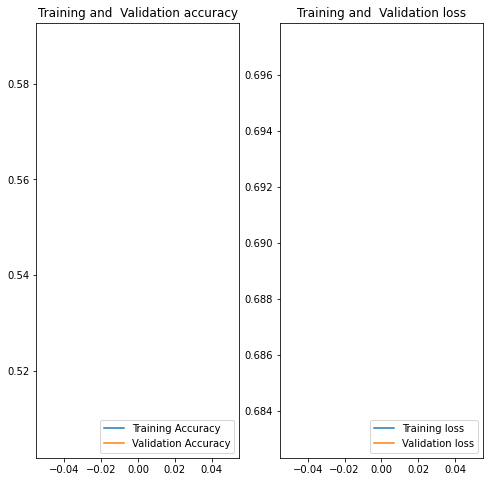

In [54]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label = 'Training Accuracy')
plt.plot(range(30), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and  Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label = 'Training loss')
plt.plot(range(30), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and  Validation loss')
plt.savefig('../reports/figures/AccVal_accVGG19.jpg')

In [56]:
# Save the mdel to be used in google Cloud

model.save('../models/Parasite_VGG19.h5')

In [ ]:
def predict(model, img):
    img_array = tensorflow.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tensorflow.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

dic = {0: 'cat', 1: 'dog'}

model = load_model('Animals.h5')

model.make_predict_function()

import numpy as np
def predict_label(img_path):
    i = image.load_img(img_path, target_size = (256, 256))
    i = image.img_to_array(i) / 255.0
    i = i.reshape(1, 256, 256, 3)
    p=model.predict(i) 
    classes_x=np.argmax(p,axis=1)
    return dic[classes_x[0]]